<a href="https://colab.research.google.com/github/patelatharva/Classify_Breast_Cancer_Type_From_Image/blob/master/tumor_type_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from glob import glob
import keras
from keras.preprocessing import image                  
from tqdm import tqdm
!pip install -q split-folders tqdm
import split_folders
import os, os.path
import imageio
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
project_dir = "/content/gdrive/My Drive/Data Scientist/breast_cancer"

In [0]:
# project_dir = "."

In [0]:
data_dir = project_dir + "/data"

In [0]:
image_source_dir = data_dir + "/originals"

### Number of samples of each type of tumor

Benign

In [8]:
len([name for name in os.listdir(image_source_dir + "/benign/") if os.path.isfile(os.path.join(image_source_dir + "/benign/", name))])

100

Malign

In [9]:
len([name for name in os.listdir(image_source_dir + "/malignant/") if os.path.isfile(os.path.join(image_source_dir + "/malignant/", name))])

150

In [0]:
image_dest_dir = data_dir + "/keras"

In [0]:
split_folders.ratio(image_source_dir, output=image_dest_dir, seed=42, ratio=(.7, .2, .1))

Copying files: 250 files [00:02, 91.69 files/s] 


In [0]:
image_width = 40
image_height = 30
if K.image_data_format() == 'channels_first':
    input_shape = (1,  image_height, image_width,)
else:
    input_shape = (image_height, image_width, 1)

In [0]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [13]:
train_generator = train_datagen.flow_from_directory(
        image_dest_dir + "/train",
        target_size=(image_height, image_width),
        batch_size=32,
        color_mode="grayscale",
        class_mode='binary',
        )

Found 175 images belonging to 2 classes.


In [0]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [15]:
validation_generator = train_datagen.flow_from_directory(
        image_dest_dir + "/val",
        target_size=(image_height, image_width),
        batch_size=32,
        color_mode="grayscale",
        class_mode='binary',
)

Found 50 images belonging to 2 classes.


In [0]:
def sensitivity(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
  spec = specificity(y_true, y_pred)
  sens = sensitivity(y_true, y_pred)
  fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
  return fmed

def f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

def generate_model(opt=keras.optimizers.Adam()):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))    
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', sensitivity, specificity, fmed, f1])
    return model

Adam Optimizer

In [274]:
num_train_samples = 10000
num_validation_samples = 1000
batch_size = 32
model = generate_model(opt=keras.optimizers.Adam())
# model.load_weights(data_dir + '/nn_best_model_cv_val_fmed.h5')
history_val_fmed = model.fit_generator(
    train_generator,
    steps_per_epoch= num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps= num_validation_samples // batch_size,
    epochs=1000, 
    verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_fmed', mode="max", verbose=1, patience=50),
          ModelCheckpoint(data_dir + '/nn_best_model_cv_val_fmed.h5', monitor='val_fmed', mode="max", verbose=1, save_best_only=True)
        ],
    class_weight=class_weights)

Epoch 1/1000
312/312 [==============================] - 52s 168ms/step - loss: 0.6041 - acc: 0.6926 - sensitivity: 0.9486 - specificity: 0.3069 - fmed: 0.4433 - f1: 0.7831 - val_loss: 0.6549 - val_acc: 0.6343 - val_sensitivity: 0.9694 - val_specificity: 0.1300 - val_fmed: 0.2129 - val_f1: 0.7585

Epoch 00001: val_fmed improved from -inf to 0.21291, saving model to /content/gdrive/My Drive/Data Scientist/breast_cancer/data/nn_best_model_cv_val_fmed.h5
Epoch 2/1000
312/312 [==============================] - 44s 141ms/step - loss: 0.5923 - acc: 0.6981 - sensitivity: 0.9507 - specificity: 0.3170 - fmed: 0.4567 - f1: 0.7874 - val_loss: 0.6254 - val_acc: 0.6576 - val_sensitivity: 0.9678 - val_specificity: 0.1890 - val_fmed: 0.2993 - val_f1: 0.7710

Epoch 00002: val_fmed improved from 0.21291 to 0.29932, saving model to /content/gdrive/My Drive/Data Scientist/breast_cancer/data/nn_best_model_cv_val_fmed.h5
Epoch 3/1000
312/312 [==============================] - 40s 128ms/step - loss: 0.5770 -

dict_keys(['val_loss', 'val_acc', 'val_sensitivity', 'val_specificity', 'val_fmed', 'val_f1', 'loss', 'acc', 'sensitivity', 'specificity', 'fmed', 'f1'])


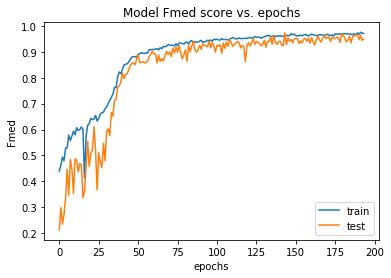

In [0]:
# list all data in history
history = history_val_fmed
print(history.history.keys())

# summarize history for fmed score
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

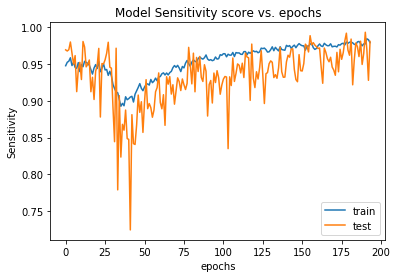

In [0]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



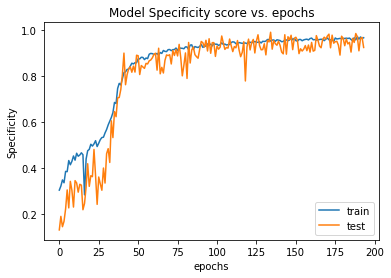

In [0]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



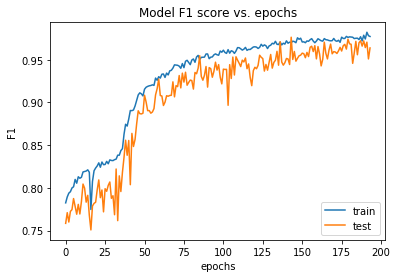

In [0]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



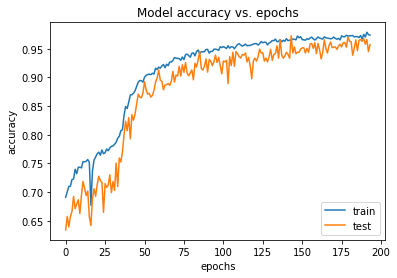

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



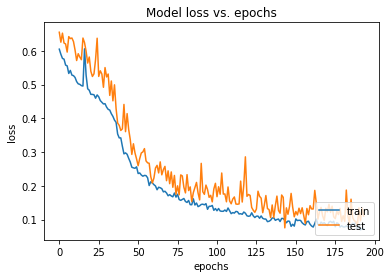

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
test_generator = train_datagen.flow_from_directory(
        image_dest_dir + "/test",
        target_size=(image_height, image_width),
        batch_size=32,
        color_mode="grayscale",
        class_mode='binary',
        shuffle=False,
        seed=42
)

Found 25 images belonging to 2 classes.


In [0]:
model = generate_model()

In [0]:
model.load_weights(data_dir + '/nn_best_model_cv_val_fmed_sgd.h5')

In [0]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

In [0]:
confusion_matrix(y_true, y_pred)

array([[ 9,  1],
       [ 2, 13]])

In [0]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [0]:
specificity = tn / (tn+fp)
specificity

0.9

In [0]:
sensitivity = tp / (tp + fn)
sensitivity

0.8666666666666667

SGD Optimizer

In [0]:
num_train_samples = 10000
num_validation_samples = 1000
batch_size = 32
model = generate_model(opt=keras.optimizers.SGD(lr=0.01, nesterov=True))
# model.load_weights(data_dir + '/nn_best_model_cv_val_fmed.h5')
history_val_fmed_sgd = model.fit_generator(
    train_generator,
    steps_per_epoch= num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps= num_validation_samples // batch_size,
    epochs=1000, 
    verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_fmed', mode="max", verbose=1, patience=100),
          ModelCheckpoint(data_dir + '/nn_best_model_cv_val_fmed_sgd.h5', monitor='val_fmed', mode="max", verbose=1, save_best_only=True)
        ],
    class_weight=class_weights)

Epoch 1/1000
312/312 [==============================] - 113s 361ms/step - loss: 0.7459 - acc: 0.5739 - sensitivity: 0.8671 - specificity: 0.1406 - fmed: 0.2025 - f1: 0.7008 - val_loss: 0.6707 - val_acc: 0.5997 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.7474

Epoch 00001: val_fmed improved from -inf to 0.00000, saving model to /content/gdrive/My Drive/Data Scientist/breast_cancer/data/nn_best_model_cv_val_fmed_sgd.h5
Epoch 2/1000
312/312 [==============================] - 37s 117ms/step - loss: 0.6712 - acc: 0.5975 - sensitivity: 0.9855 - specificity: 0.0244 - fmed: 0.0437 - f1: 0.7415 - val_loss: 0.6571 - val_acc: 0.6003 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.7475

Epoch 00002: val_fmed did not improve from 0.00000
Epoch 3/1000
312/312 [==============================] - 36s 117ms/step - loss: 0.6620 - acc: 0.6034 - sensitivity: 0.9730 - specificity: 0.0519 - fmed: 0.0899 - f1: 0.7422 - v

In [0]:
# list all data in history
history = history_val_fmed_sgd
print(history.history.keys())

# summarize history for fmed score
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [0]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [0]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [0]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



In [21]:
test_generator = train_datagen.flow_from_directory(
        image_dest_dir + "/test",
        target_size=(image_height, image_width),
        batch_size=32,
        color_mode="grayscale",
        class_mode='binary',
        shuffle=False,
        seed=42
)

Found 25 images belonging to 2 classes.


In [0]:
model = generate_model(opt=keras.optimizers.SGD(lr=0.01, nesterov=True))

In [0]:
model.load_weights(data_dir + '/nn_best_model_cv_val_fmed_sgd.h5')

In [0]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

In [25]:
confusion_matrix(y_true, y_pred)

array([[10,  0],
       [ 2, 13]])

In [0]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [27]:
specificity = tn / (tn+fp)
specificity

1.0

In [28]:
sensitivity = tp / (tp + fn)
sensitivity

0.8666666666666667